# Week 4: Regularization and Hyperparameter Tuning

This week, we take a dive into how to improve the performance of our machine learning models. We will focus on regression problems, where we try to predict a numerical value, but the ideas herein are pretty universal across supervised machine learning.

First, **regularization** methods sometimes help improve a model's ability to make good predictions on the test set, often at the expense of training accuracy. We focus on some methods developed by mathematician Andrey Tikhonov and used for solving ill-posed inverse problems. Some special cases of his methods and new innovations have become incredibly popular in machine learning.

Second, machine learning models we have seen have trainable parameters determined by a learning algorithm, such as the coefficients in linear regression and the shape and prototype parameters in radial basis functions. **Hyperparameters** are numbers we set or decisions we make before running learning algorithms. Wednesday, we focus on effectively making these choices for performance, or **tuning** them.

## Lecture 12: Regularization and Overfitting

The problem of **overfitting** is an issue where a machine learning model fits too strongly to the training data, which reduces its ability to generalize to make good predictions on the test set. High performance on the test set is typically our most important goal, because this measures how the model performs on data it has not seen before, indicating the model should perform well on real-world data, assuming the test data are representative of the data we hope to predict.

Below, we implement ridge regression, which imposes an $L^2$ penalty on the model parameters to minimize the loss function

$$L(\theta) = \|\theta_0 + X\theta - y\| + \lambda_2\|\theta\|^2$$

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

In [19]:
class RidgeRegression:
    
    def __init__(self, alpha = 0.001, lambda2 = 0):
        # save variables to object memory
        self.alpha = alpha
        self.lambda2 = lambda2
        
    # fit the model to the data
    def fit(self, X, y, epochs = 1000, update = 100):
        # find the dimension of the data
        d = X.shape[1]
        
        # initialize the model parameters
        self.theta0 = np.random.uniform()
        self.theta = np.random.uniform(size = d)
        
        # compute the means of X and y
        yMean = np.mean(y)
        xMean = np.mean(X, axis = 0)
        
        # standardize the data
        X = scale(X)
        y = scale(y)
        
        # compute a scaling parameter
        eta = np.linalg.norm(X)
        
        # train the model
        for i in range(epochs):
            # compute the predicted y values
            predictions = self.theta0 + X @ self.theta
            
            # compute the error
            error = predictions - y
            
            # compute the sum of squared errors
            sse = np.sum(error ** 2)
            
            # compute the loss
            loss = sse + self.lambda2 * np.linalg.norm(self.theta) ** 2 #+ self.lambda1 * np.sum(np.abs(self.theta))

            # print an update
            if (i + 1) % update == 0:
                print('Epoch', i + 1, '\tLoss', loss)
                                                
            # weight update for the bias
            self.theta -= self.alpha * (X.T @ error + 2 * self.lambda2 * self.theta)
            self.theta0 = yMean - xMean @ self.theta

    # predict the output from input (testing) data
    def predict(self, X):
        # return the predicted outputs
        return self.theta0 + X @ self.theta

Epoch 10 	Loss 15.05275147027944
Epoch 20 	Loss 7.887071048336132
Epoch 30 	Loss 4.647494921498687
Epoch 40 	Loss 3.5327727503535247
Epoch 50 	Loss 3.5112983932797017
Epoch 60 	Loss 4.003245884168101
Epoch 70 	Loss 4.691697499814393
Epoch 80 	Loss 5.4109096821794385
Epoch 90 	Loss 6.080600023719182
Epoch 100 	Loss 6.667606503805849
The predicted y values are [2.14838242 2.37419121 2.6        2.82580879 3.05161758]
The real y values are [1 2 3 3 4]
The theta values are [0.79352967 0.22580879]
The r^2 score is 0.5098898029889929
The mean squared error is 0.5097146048914476
The mean absolute error is 0.609029450487268


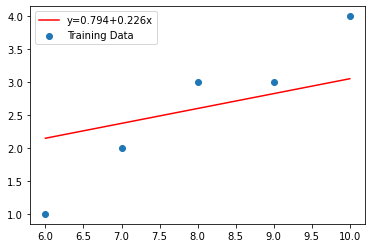

In [20]:
X = np.array([[6], [7], [8], [9], [10]])
y = np.array([1, 2, 3, 3, 4])

model = RidgeRegression(lambda2 = 10)
model.fit(X, y, epochs = 100, update = 10)
predictions = model.predict(X)

# print the predictions
print('The predicted y values are', predictions)

# print the real y values
print('The real y values are', y)

# print the beta values
parameters = np.concatenate((np.atleast_1d(model.theta0), model.theta))
print('The theta values are', parameters)

# plot the training points
plt.scatter(X, y, label = 'Training Data')

# plot the fitted model with the training data
xModel = np.linspace(6,10,100)
yModel = parameters[0] + parameters[1]*xModel
lineFormula = 'y={:.3f}+{:.3f}x'.format(parameters[0], parameters[1])
plt.plot(xModel, yModel, 'r', label = lineFormula)

# add a legend
plt.legend()

# return quality metrics
print('The r^2 score is', r2_score(y, predictions))
print('The mean squared error is', mean_squared_error(y, predictions))
print('The mean absolute error is', mean_absolute_error(y, predictions))

## Lecture 12: Hyperparameter Tuning and Crossvalidation

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [4.6 3.4 1.4 0.3]
 [5.  3.4 1.5 0.2]
 [4.4 2.9 1.4 0.2]
 [4.9 3.1 1.5 0.1]
 [5.4 3.7 1.5 0.2]
 [4.8 3.4 1.6 0.2]
 [4.8 3.  1.4 0.1]
 [4.3 3.  1.1 0.1]
 [5.8 4.  1.2 0.2]
 [5.7 4.4 1.5 0.4]
 [5.4 3.9 1.3 0.4]
 [5.1 3.5 1.4 0.3]
 [5.7 3.8 1.7 0.3]
 [5.1 3.8 1.5 0.3]
 [5.4 3.4 1.7 0.2]
 [5.1 3.7 1.5 0.4]
 [4.6 3.6 1.  0.2]
 [5.1 3.3 1.7 0.5]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.  3.4 1.6 0.4]
 [5.2 3.5 1.5 0.2]
 [5.2 3.4 1.4 0.2]
 [4.7 3.2 1.6 0.2]
 [4.8 3.1 1.6 0.2]
 [5.4 3.4 1.5 0.4]
 [5.2 4.1 1.5 0.1]
 [5.5 4.2 1.4 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.2 1.2 0.2]
 [5.5 3.5 1.3 0.2]
 [4.9 3.6 1.4 0.1]
 [4.4 3.  1.3 0.2]
 [5.1 3.4 1.5 0.2]
 [5.  3.5 1.3 0.3]
 [4.5 2.3 1.3 0.3]
 [4.4 3.2 1.3 0.2]
 [5.  3.5 1.6 0.6]
 [5.1 3.8 1.9 0.4]
 [4.8 3.  1.4 0.3]
 [5.1 3.8 1.6 0.2]
 [4.6 3.2 1.4 0.2]
 [5.3 3.7 1.5 0.2]
 [5.  3.3 1.4 0.2]
 [7.  3.2 4.7 1.4]
 [6.4 3.2 4.5 1.5]
 [6.9 3.1 4.